## Solving Traveling Salesman Problem using Simulated Annealing

### Converge to a local minimum total distance

In [1]:
import re
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read the file and write nodes as dict
def read_tsp_file(file_path):
    cities = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
        node_coord_section = False
        for line in lines:
            line = line.strip()
            if line == "EOF":
                break
            if line.startswith("NODE_COORD_SECTION"):
                node_coord_section = True
            elif node_coord_section and line:
                parts = line.split()
                city_id = int(parts[0])
                x_coord = float(parts[1])
                y_coord = float(parts[2])
                cities[city_id] = (x_coord, y_coord)
    return cities


def read_tour_file(filename):
    with open(filename, 'r') as file:
        lines = file.read().splitlines()
    tour = []
    for line in lines:
        if line.startswith('TOUR_SECTION'):
            break
    for line in lines[lines.index('TOUR_SECTION') + 1:]:
        if line.strip() == '-1' or re.match(r'EOF', line.strip()):
            break
        tour.append(int(line.strip()))
    return tour

In [3]:
# use euclidean distance because in tsp file the EDGE_WEIGHT_TYPE is 'EUC_2D'
def euclidean_distance(city1, city2):
    return math.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)

def total_distance(path, cities):
    total_distance = 0
    for i in range(-1, len(path) - 1):
        total_distance += euclidean_distance(cities[path[i]], cities[path[i + 1]])
    return total_distance

def two_opt_swap(path, i, k):
    new_path = path[:i]
    new_path.extend(reversed(path[i:k + 1]))
    new_path.extend(path[k + 1:])
    return new_path

In [4]:
def simulated_annealing(cities, path, temperature = 100, cooling_rate = 0.99, min_temperature = 0.1, iterations=500):
     
    current_path = path   
    min_path = current_path.copy()
    min_distance = total_distance(min_path, cities)

    distances = []

    while temperature > min_temperature:
        for _ in range(iterations):
            i, k = sorted(random.sample(range(len(path)), 2))

            new_path = two_opt_swap(path, i, k)
            new_distance = total_distance(new_path, cities)

            # Decide whether to accept the new solution
            if new_distance < min_distance or random.random() < math.exp((min_distance - new_distance) / temperature):
                min_distance, path = new_distance, new_path
                if new_distance < total_distance(min_path, cities):
                    min_path = new_path.copy()

            distances.append(min_distance)

        temperature *= cooling_rate

    return min_path, min_distance, distances

For the case of 51 cities, the total distance is 434.94.
For the case of 280 cities, the total distance is 2770.75.
For the case of 442 cities, the total distance is 52040.42.


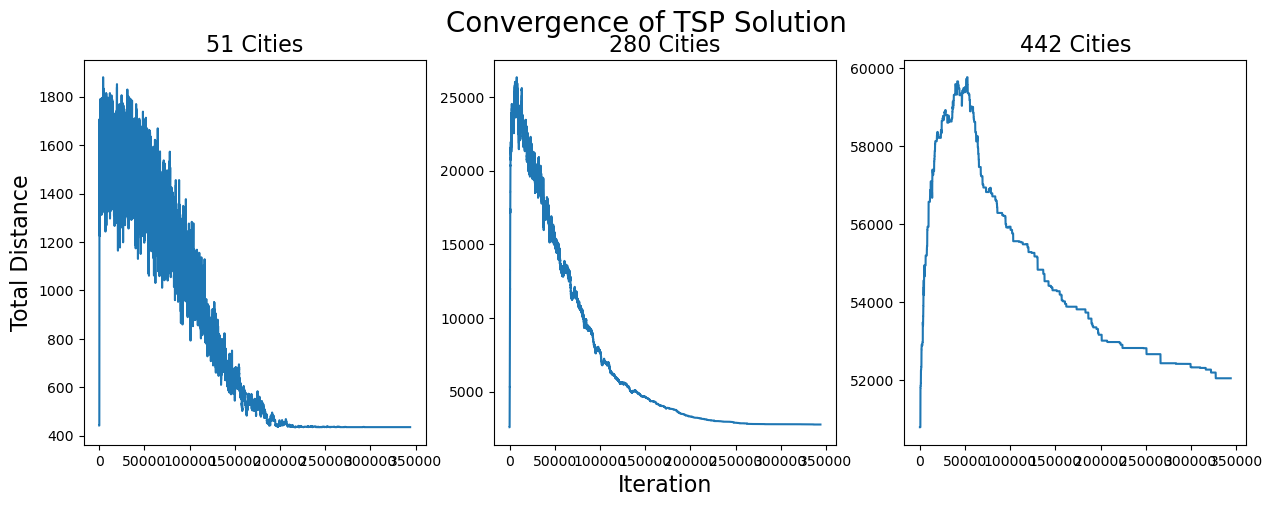

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

file_path_list = ['eil51.tsp.txt', 'a280.tsp.txt', 'pcb442.tsp.txt']
file_path_list2 = ['eil51.opt.tour.txt', 'a280.opt.tour.txt', 'pcb442.opt.tour.txt']

for i in range(3):
    cities = read_tsp_file(file_path_list[i])
    path = read_tour_file(file_path_list2[i])
    best_path, best_distance, distances = simulated_annealing(cities, path)
    
    print(f"For the case of {len(cities)} cities, the total distance is {best_distance:.2f}.")
    
    axs[i].plot(distances)

    axs[i].set_title(f"{len(cities)} Cities", fontsize=16)
    axs[1].set_xlabel("Iteration", fontsize=16)
    axs[0].set_ylabel("Total Distance", fontsize=16)
    
    
plt.suptitle("Convergence of TSP Solution", fontsize=20)    
plt.savefig("convergence", dpi=300)

### Different cooling schedules and their effects on convergence

In [6]:
def read_tsp_file(file_path):
    cities = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
        node_coord_section = False
        for line in lines:
            line = line.strip()
            if line == "EOF":
                break
            if line.startswith("NODE_COORD_SECTION"):
                node_coord_section = True
            elif node_coord_section and line:
                parts = line.split()
                city_id = int(parts[0])
                x_coord = float(parts[1])
                y_coord = float(parts[2])
                cities[city_id] = (x_coord, y_coord)
    return cities

# use euclidean distance because in tsp file the EDGE_WEIGHT_TYPE is 'EUC_2D'
def euclidean_distance(city1, city2):
    return math.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)

def total_distance(path, cities):
    return sum(euclidean_distance(cities[path[i]], cities[path[i - 1]]) for i in range(len(path)))

def two_opt_swap(path, i, k):
    new_path = path[:i]
    new_path.extend(reversed(path[i:k + 1]))
    new_path.extend(path[k + 1:])
    return new_path

# change file_path to change the cities' configuration
file_path = 'a280.tsp.txt'
cities = read_tsp_file(file_path)


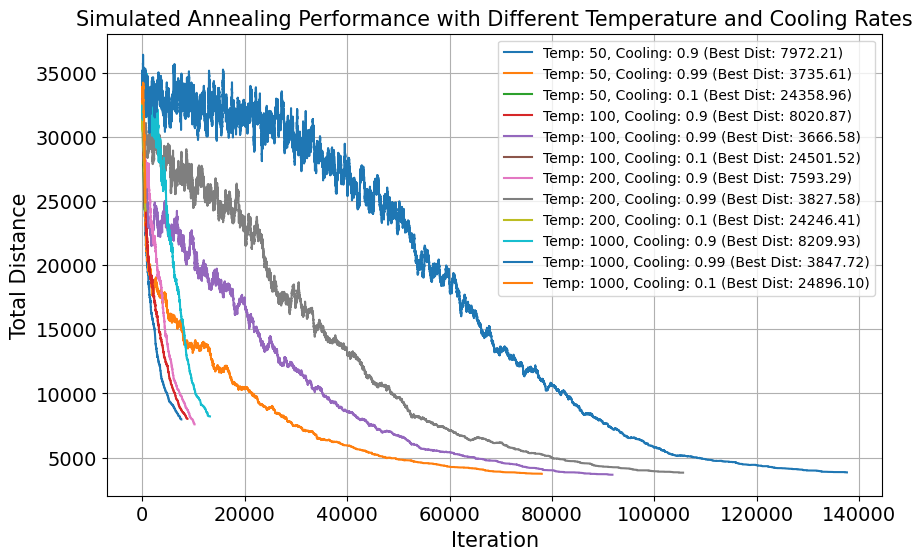

In [7]:
def simulated_annealing(cities, temperature=100, cooling_rate=0.99, min_temperature=1, iterations=200):
    path = list(cities.keys())
    random.shuffle(path)

    min_distance = total_distance(path, cities)
    min_path = path.copy()

    distances = []

    while temperature > min_temperature:
        for _ in range(iterations):
            i, k = sorted(random.sample(range(len(path)), 2))
            new_path = two_opt_swap(path, i, k)
            new_distance = total_distance(new_path, cities)

            if new_distance < min_distance or random.random() < math.exp((min_distance - new_distance) / temperature):
                min_distance, path = new_distance, new_path
                if new_distance < total_distance(min_path, cities):
                    min_path = new_path.copy()

            distances.append(min_distance)

        temperature *= cooling_rate

    return min_path, min_distance, distances

# Function to run experiments with different temperature and cooling rate configurations
def run_simulated_annealing_experiments(cities, temperature_configs):
    results = {}
    for temp, cooling in temperature_configs:
        _, best_distance, distances = simulated_annealing(cities, temperature=temp, cooling_rate=cooling)
        results[(temp, cooling)] = best_distance, distances
    return results

# Function to plot the results
    

def plot_results(results):
    plt.figure(figsize=(10, 6))
    for (temp, cooling), (best_distance, distances) in results.items():
        plt.plot(distances, label=f"Temp: {temp}, Cooling: {cooling} (Best Dist: {best_distance:.2f})")
    
    plt.xlabel("Iteration", fontsize=15)
    plt.ylabel("Total Distance", fontsize=15)
    plt.title("Simulated Annealing Performance with Different Temperature and Cooling Rates", fontsize=15)
    plt.legend()
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

# Temperature and cooling rate configurations
temperature_configs = [
    (50, 0.9),   # Low temperature, fast cooling
    (50, 0.99), 
    (50, 0.1), # Low temperature, slow cooling
    (100, 0.9),  # Medium temperature, fast cooling
    (100, 0.99), 
    (100, 0.1),# Medium temperature, slow cooling
    (200, 0.9),  # High temperature, fast cooling
    (200, 0.99), 
    (200, 0.1),# High temperature, slow cooling
    (1000, 0.9),
    (1000, 0.99),
     (1000, 0.1),
    
]

# Read cities from the file
file_path = 'a280.tsp.txt'
cities = read_tsp_file(file_path)

# Run experiments
experiment_results = run_simulated_annealing_experiments(cities, temperature_configs)

# Plot the results
plot_results(experiment_results)


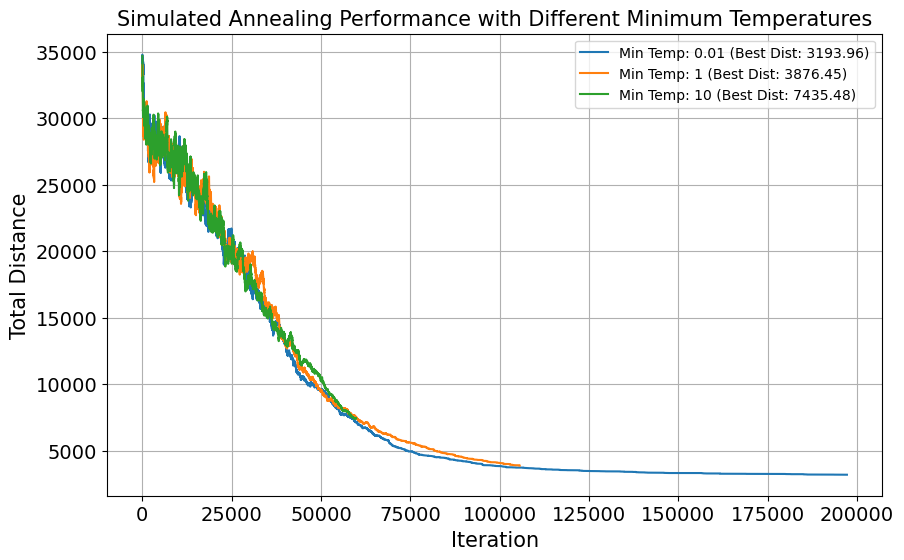

In [8]:
# Function to run experiments with different minimum temperatures
def run_min_temp_experiments(cities, temp, cooling, min_temperatures, iterations=200):
    results = {}
    for min_temp in min_temperatures:
        _, best_distance, distances = simulated_annealing(cities, temperature=temp, cooling_rate=cooling, min_temperature=min_temp, iterations=iterations)
        results[min_temp] = best_distance, distances
    return results

# Function to plot the results for experiments with different minimum temperatures
def plot_min_temp_results(results):
    plt.figure(figsize=(10, 6))
    for min_temp, (best_distance, distances) in results.items():
        plt.plot(distances, label=f"Min Temp: {min_temp} (Best Dist: {best_distance:.2f})")
    
    plt.xlabel("Iteration", fontsize=15)
    plt.ylabel("Total Distance", fontsize=15)
    plt.title("Simulated Annealing Performance with Different Minimum Temperatures", fontsize=15)
    plt.legend()
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

# Selected best performing temperature and cooling rate from previous experiments
selected_temp = 200
selected_cooling = 0.99

# Different minimum temperatures to test
min_temperatures = [0.01, 1, 10]

# Run experiments with different minimum temperatures
min_temp_results = run_min_temp_experiments(cities, selected_temp, selected_cooling, min_temperatures)

# Plot the results with different minimum temperatures
plot_min_temp_results(min_temp_results)


### The effect of Markov chain length on convergence in the Traveling Salesman Problem simulated annealing algorithm


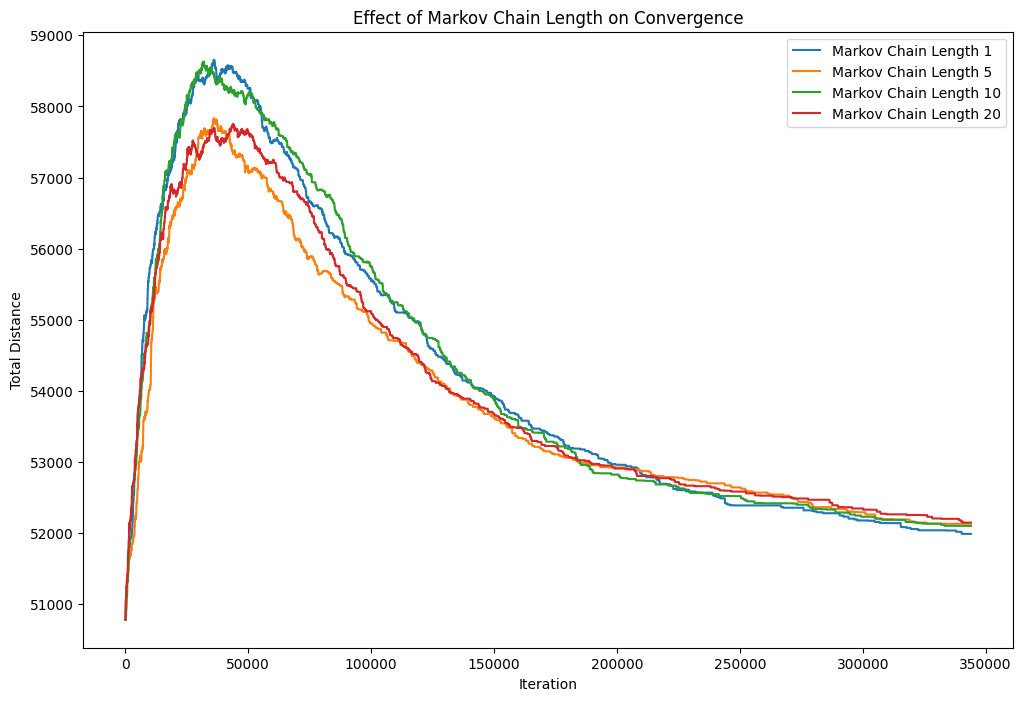

In [ ]:
def markov_length_effect2(cities, path, temperature, cooling_rate, min_temperature, iterations, markov_lengths, runs=5):
    results = {}
    convergence_speed = {}

    for length in markov_lengths:
        all_distances = []
        for _ in range(runs):
            _, _, distances = simulated_annealing(
                cities, path, temperature, cooling_rate, min_temperature, iterations
            )
            all_distances.append(distances)
        
        # mean distance
        average_distances = np.mean(all_distances, axis=0)
        results[length] = average_distances

        # Determine convergence speed
        target_distance = np.min(average_distances) * 1.05  # Target set to 105% of the best found
        for i, dist in enumerate(average_distances):
            if dist <= target_distance:
                convergence_speed[length] = i
                break

    return results, convergence_speed

# Make sure to define the simulated_annealing function above this point

# Example usage
markov_lengths = [1, 5, 10, 20]  # Example Markov Chain lengths
cities = read_tsp_file('pcb442.tsp.txt')
path = read_tour_file('pcb442.opt.tour.txt')
temperature = 100
cooling_rate = 0.99
min_temperature = 0.1
iterations = 500
results, convergence_speed = markov_length_effect2(cities, path, temperature, cooling_rate, min_temperature, iterations, markov_lengths)

# Plotting the distances
plt.figure(figsize=(12, 8))
for length, distances in results.items():
    plt.plot(distances, label=f'Markov Chain Length {length}')

plt.xlabel('Iteration')
plt.ylabel('Total Distance')
plt.title('Effect of Markov Chain Length on Convergence')
plt.legend()
plt.show()
